# Excersize

Develop algorithm to clasify language of the document, for e.g:

* 1000 samples of EN
* 1000 samples of DE
* 1000 samples x FR

After that you are getting a document in one of those languages:

1 x ??
Your task is to classify the language of the document.

# Answer

## Problem analysis

I am dealing with classification problem within supervised learning domain. Known sets of publications compose labeled data which language is known. Most important in such pipelines is text data preprocessing. This determines algorithm learning speed and accuracy. In general very popular method is based on counting words or letters frequency in the studied text. 

Unlike structured, numeric or categorical data, text processing is far more challenging in context of pre-processing and normalizing as well as feature extraction and engineering. Without normalization process feature extraction will not work, leading to poor model training data and poor model performance. Therefore preprocessing part is a key element in each text analysis task.

Furthermore I would like to discuss method of identifying specific language. Unlike topic modeling, when one needs to dive deep into the text and check most relevant words and try to classify them, minimizing information loss, identifying language may be best to be done using all preparation techniques, which try to strip texts from language characteristic elements. Therefore it may be quite  efficient way to identify language:

* stop words (most common words in a language) - most natural and naive approach
* train deep neural net using all above characteristics (stop words, special characters, most popular characters) as additional features for the algorithm.


## Tools

Python library, which allows to work on text is NLTK (Natural Language Tool Kit). To start work with t some preparations may be necessary (for examle downloading specific language data). 

For standard data pre-processing procedures I will use scikit-learn library.

For designing nerual network I will use keras and tensorflow as a backend. To visualize Deep Neural Network I use pydot and keras utilities.

To visualize progress I will use matplotlib for basic 2D plots.

In [ ]:
## Insdtall NLTK and other tools
# Some of them should be already part of Anaconda bundle
!conda install -c conda-forge --yes nltk numpy matplotlib scikit-learn tensorflow keras, pydot

In [ ]:
import nltk

# Download NLTK datasets to process different languages
nltk.download('popular', halt_on_error=False)

In [ ]:
# I would like to install some training data set, for instance European Parliament Proceedings Parallel Corpus
# http://www.statmt.org/europarl/
nltk.download('europarl_raw', halt_on_error=False)

## Text data

In the example text data were virtual collections of large amount of documents for three speciffic language. I would like to procure more substantial numerical experiment, therefore will use publicly accessible data set (already downloaded). I will use single book for each language from Project Gutenberg and see how specific method works.

I have chosen fragments of following books:

* EN: Mark Twain Adventures of Huckleberry Finn
* FR: Victor Hugo LES MISÉRABLES
* DE: Thomas Mann Der Tod in Venedig

# Building solutions

## Stop words approach

What I will do is calculate stop words frequency for each language, using downloaded books I can assume, that they will be fair sample for each language, therefore there is no need to use EU dataset.
I have data set with known labels (I know which documents are en, fr or de). I will use list of stop words provided by NLTK library to calculate frequency of each language stop words in my documents. Highest mark means highest probability.. Once 

In [1]:
def read_book(file):
    with open(file, 'r', encoding="utf-8") as f:
        book = f.read()
        return book

In [2]:
languages_dict = {'english':0,'french':1,'german':2}

In [3]:
de = read_book('de.txt')
fr = read_book('fr.txt')
en = read_book('en.txt')

In [4]:
# Lets prepare Identifier class
class LanguageIdentifier:
    
    def __init__(self, text):
        self.text = text
        self.stop_words = self.get_stop_words()
        self.words = self.tokenize()
        self.language_score = self.get_score()
        self.language = self.identify_language()
    
    def tokenize(self):
        try:
            import nltk
            tokenizer = nltk.word_tokenize
            tokens = tokenizer(text=self.text)
            words = [word.lower() for word in tokens]
            return words
        except ImportError as e:
            print("NLTK must be installed. {}".format(e))

    def get_stop_words(self):
        try:
            from nltk.corpus import stopwords
            return stopwords
        except ImportError as e:
            print("NLTK must be installed. {}".format(e))
            
    def get_score(self):
        _language_score = {}
        for language in self.stop_words.fileids():
            stopwords_set = set(self.stop_words.words(language))
            words_set = set(self.words)
            common_elements = words_set.intersection(stopwords_set)
            
            _language_score[language] = len(common_elements)
        return _language_score
    

    def identify_language(self):
        return max(self.language_score, key=self.language_score.get)

In [5]:
%timeit LanguageIdentifier(text=en).identify_language()
%timeit LanguageIdentifier(text=fr).identify_language()
%timeit LanguageIdentifier(text=de).identify_language()

1.43 s ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.8 s ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
398 ms ± 9.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
print(LanguageIdentifier(text=en).identify_language())
print(LanguageIdentifier(text=fr).identify_language())
print(LanguageIdentifier(text=de).identify_language())

english
french
german


In [7]:
%timeit LanguageIdentifier(text=en[:100]).identify_language()
%timeit LanguageIdentifier(text=fr[:100]).identify_language()
%timeit LanguageIdentifier(text=de[:100]).identify_language()

10.8 ms ± 204 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.5 ms ± 67.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.5 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
print(LanguageIdentifier(text=en[:100]).identify_language())
print(LanguageIdentifier(text=fr[:100]).identify_language())
print(LanguageIdentifier(text=de[:100]).identify_language())

english
french
german


## Summary of stop-words

PROS:

1. No model to train
2. Works with small samples
3. Very short pore-processing
4. Simple

CONS:
1. Pretty slow for large samples
2. May be completely inaccurate in case of languages sharing some stop words. All examples here are quite distinct.
3. No metrics regarding accuracy

## Neural net approach


In this example we can use similar approach as in stop words approach, but now, instead of words, I will  count occurrence frequency of all the letters from tested languages alphabets. Assuming I have only 3 languages, I can exactly know which letters can occur in such texts and determine their frequency. This should work also for languages closely related, because they will differ in letters distribution. Then I will feed this features to the Deep Neural Net and train a classifier.

To train model I will use three books downloaded from Project Gutenberg, but I will split data for training and test groups.

In [9]:
letters = {'base_en': 'abcdfeghijklmnopqrstuvwxyz',
           'german':'äöüß',
           'french': 'àâæçéèêêîïôœùûüÿ'}
special_chars = ' !?'

In [10]:
# List of all letters , signs for English, French and German
class Alphabet:
    def __init__(self, kwargs):
#         TODO, Instead of dictionary list of files and method to create alphabet out of text
        self._chars = kwargs
        self._combined_chars_lower = self.combine_chars()
        self._combined_chars_upper = self.combine_chars().upper()
        self._lower__chars_list = sorted(self.get_lower_chars_list())
        self._upper_chars_list = sorted(self.get_upper_chars_list())
        self._all_chars_list = self._lower__chars_list + self._upper_chars_list

    def combine_chars(self):
        _all_chars = ''
        for key, val in self._chars.items():
            _all_chars += val
        _all_chars = sorted(_all_chars)
        _all_chars = ''.join([str(char) for char in _all_chars])
        return _all_chars
    
    def get_lower_chars_list(self):
        return list(set(list(self._combined_chars_lower.lower())))
    
    def get_upper_chars_list(self):
        return list(set(list(self._combined_chars_upper)))

In [11]:
alphabet = Alphabet(letters)

In [12]:
alphabet._chars

{'base_en': 'abcdfeghijklmnopqrstuvwxyz',
 'german': 'äöüß',
 'french': 'àâæçéèêêîïôœùûüÿ'}

In [13]:
alphabet._combined_chars_lower

'abcdefghijklmnopqrstuvwxyzßàâäæçèéêêîïôöùûüüÿœ'

In [14]:
alphabet._combined_chars_upper

'ABCDEFGHIJKLMNOPQRSTUVWXYZSSÀÂÄÆÇÈÉÊÊÎÏÔÖÙÛÜÜŸŒ'

In [15]:
print(alphabet._lower__chars_list)
print(alphabet._upper_chars_list)
print(alphabet._all_chars_list)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ß', 'à', 'â', 'ä', 'æ', 'ç', 'è', 'é', 'ê', 'î', 'ï', 'ô', 'ö', 'ù', 'û', 'ü', 'ÿ', 'œ']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'À', 'Â', 'Ä', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Î', 'Ï', 'Ô', 'Ö', 'Ù', 'Û', 'Ü', 'Œ', 'Ÿ']
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ß', 'à', 'â', 'ä', 'æ', 'ç', 'è', 'é', 'ê', 'î', 'ï', 'ô', 'ö', 'ù', 'û', 'ü', 'ÿ', 'œ', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'À', 'Â', 'Ä', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Î', 'Ï', 'Ô', 'Ö', 'Ù', 'Û', 'Ü', 'Œ', 'Ÿ']


### Red data

In [16]:
def read_book(file):
    with open(file, 'r', encoding="utf-8") as f:
        book = f.read()
        return book

In [17]:
de = read_book('de.txt')
fr = read_book('fr.txt')
en = read_book('en.txt')

### Clean data

In [18]:
import re

def remove_newlines(text):
    return text.replace('\n', ' ') 

def remove_manyspaces(text):
    return re.sub(r'\s+', ' ', text)

def clean_non_text(text):
    return re.sub(r'^a-zA-Z\d\s:', ' ', text)
def clean_double_minus(text):
    return re.sub(r'(--)+', ' ', text)

def clean_text(text):
    text = remove_newlines(text)
    text = clean_non_text(text)
    text = remove_manyspaces(text)
    text= clean_double_minus(text)
    return text

In [19]:
clear_en = clean_text(en)
clear_de = clean_text(de)
clear_fr = clean_text(fr)

In [20]:
print(len(clear_en)/100)
print(len(clear_de)/100)
print(len(clear_fr)/100)

5859.71
1893.0
6718.0


In [21]:
# Make smaples
# Files are books, therefore I skip shuffling the words
n=100
parts_en = [clear_en[i:i+n] for i in range(0, len(clear_en), n)]
parts_de = [clear_de[i:i+n] for i in range(0, len(clear_de), n)]
parts_fr = [clear_fr[i:i+n] for i in range(0, len(clear_fr), n)]


1. Create features space. Our features will be vectors with numbers indicating amount of specific letter in each text sample. We simply iterate text sign, by sign and check how many times specific letter occurred.
2. Scale data
3. perform PCA

In [22]:
def count_chars(text,alphabet, target):
    alphabet_counts = []
    for letter in alphabet:
        count = text.count(letter)
        alphabet_counts.append(count)
    # Y vector for each sample
    alphabet_counts.append(target)
    return alphabet_counts

In [23]:
languages_dict = {'english':0,'french':1,'german':2}

In [24]:
import numpy as np
# TODO refactor repeated parts of CODE
vectors_de = []
for item in parts_de:
    count = count_chars(item, alphabet._all_chars_list, 2)
    vectors_de.append(count)
#     vectors_de.append(2)
np_vectors_de = np.array(vectors_de)

In [25]:
vectors_en = []
for item in parts_en:
    count = count_chars(item, alphabet._all_chars_list, 0)
    vectors_en.append(count)
#     vectors_en.append(0)
np_vectors_en = np.array(vectors_en)

In [26]:
vectors_fr = []
for item in parts_fr:
    count = count_chars(item, alphabet._all_chars_list, 1)
    vectors_fr.append(count)
np_vectors_fr = np.array(vectors_fr)

In [27]:
print(np_vectors_de.shape)
print(np_vectors_en.shape)
print(np_vectors_fr.shape)

(1893, 88)
(5860, 88)
(6718, 88)


In [28]:
# Stack data
data = np.concatenate([np_vectors_en, np_vectors_fr, np_vectors_de])

In [29]:
# Randomize data rows order, modifies in place
np.random.shuffle(data)

In [31]:
# Extract features data set and target data set
from keras.utils import to_categorical

X_data = data[:,0:data.shape[1]-1]
Y = data[:,-1]
# Y 
Y_data = to_categorical(Y, num_classes=len(languages_dict))
# y_test = keras.utils.to_categorical(np.random.randint(10, size=(100, 1)), num_classes=10)


In [32]:
Y_data.shape

(14471, 3)

In [33]:
X_data.shape

(14471, 87)

In [34]:
# Scale data using scikit-learn preprocessing module.
# Standardize features by removing the mean and scaling to unit variance

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_data)

C:\Users\Alicja\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [35]:
X_scaled = scaler.transform(X_data)

C:\Users\Alicja\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [36]:
X_scaled.shape

(14471, 87)

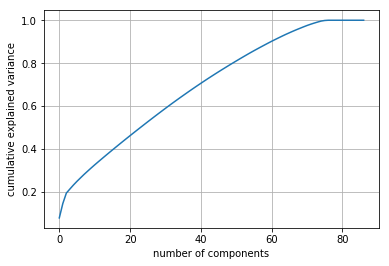

In [38]:
# Due to large feature space (87 features)
# it is good to perform Principle Component Analysis (PCA)
# to select most meaningful features to train Neural network
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

pca = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()
plt.show()

It appears I need Around 70 features. We shall see how PCA influenced time of training. I will perform two parallel DNN trainings and compare them.

In [39]:
# Prepare training and test data sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_data, test_size=0.2,
                                                    random_state=1, 
                                                    stratify=Y_data)


### Modeling (algorithm training)

TIme to create Deep Neural Net to be used to train classifier. I am using Keras wrapper with TensorFlow back-end.

#### Network topology

Network topology is dictated by data shape after PCA transformation. Some useful practices in setting hidden layer topology are:

1. Use as many hidden nodes as dimensions (principal components) needed to capture 70-90% of the variance of the input data (70 in this case)
2. hidden layer i should never be more than twice as large as the input layer.

In [40]:
input_size = X_scaled.shape[1]

In [41]:
2*input_size

174

In [42]:
# create DNN using Keras Sequential API
# I added Dropout to prevent overfitting
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(176,input_dim=input_size,kernel_initializer="glorot_uniform",activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(176,kernel_initializer="glorot_uniform",activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(88,kernel_initializer="glorot_uniform",activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(len(languages_dict),kernel_initializer="glorot_uniform",activation="softmax"))
model_optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=model_optimizer,
              metrics=['accuracy'])

In [43]:
# from keras.utils import plot_model
# plot_model(model, to_file='model.png')

In [44]:
# let's fit the data
# history variable will help us to plot results later
history = model.fit(X_train,y_train,
          epochs=12,
          validation_split=0.10,
          batch_size=64,
          verbose=2,
          shuffle=True)

Train on 10418 samples, validate on 1158 samples
Epoch 1/12
 - 1s - loss: 1.0525 - acc: 0.4376 - val_loss: 0.9751 - val_acc: 0.4853
Epoch 2/12
 - 1s - loss: 0.9944 - acc: 0.4641 - val_loss: 0.9737 - val_acc: 0.4033
Epoch 3/12
 - 1s - loss: 0.9832 - acc: 0.4865 - val_loss: 0.9461 - val_acc: 0.7945
Epoch 4/12
 - 1s - loss: 0.9510 - acc: 0.5373 - val_loss: 0.8497 - val_acc: 0.8307
Epoch 5/12
 - 1s - loss: 0.7904 - acc: 0.6707 - val_loss: 0.4739 - val_acc: 0.8575
Epoch 6/12
 - 1s - loss: 0.5177 - acc: 0.8050 - val_loss: 0.3211 - val_acc: 0.8584
Epoch 7/12
 - 1s - loss: 0.4146 - acc: 0.8362 - val_loss: 0.2911 - val_acc: 0.8584
Epoch 8/12
 - 1s - loss: 0.3766 - acc: 0.8482 - val_loss: 0.2606 - val_acc: 0.8739
Epoch 9/12
 - 1s - loss: 0.3365 - acc: 0.8743 - val_loss: 0.2192 - val_acc: 0.9171
Epoch 10/12
 - 1s - loss: 0.3133 - acc: 0.8851 - val_loss: 0.1969 - val_acc: 0.9335
Epoch 11/12
 - 1s - loss: 0.2935 - acc: 0.8970 - val_loss: 0.1690 - val_acc: 0.9499
Epoch 12/12
 - 1s - loss: 0.2579 - a

### Model evaluation

In [45]:

# What is our model real accuracy tested on unseen data?
scores = model.evaluate(X_test, y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

2895/2895 [==============================] - 0s 55us/step
acc: 96.03%


In [47]:
from keras.utils import to_categorical
# and now we will prepare data for scikit-learn classification report
Y_pred = model.predict_classes(X_test)
Y_pred = to_categorical(Y_pred, num_classes=len(languages_dict))

In [49]:
# and run the report
from sklearn.metrics import classification_report
target_names =  list(languages_dict.keys())
print(classification_report(y_test, Y_pred, target_names=target_names))

             precision    recall  f1-score   support

    english       0.94      0.98      0.96      1172
     french       0.99      0.98      0.98      1344
     german       0.92      0.82      0.87       379

avg / total       0.96      0.96      0.96      2895



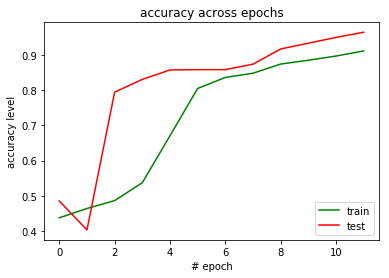

In [50]:
# show plot accuracy changes during training
plt.plot(history.history['acc'],'g')
plt.plot(history.history['val_acc'],'r')
plt.title('accuracy across epochs')
plt.ylabel('accuracy level')
plt.xlabel('# epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

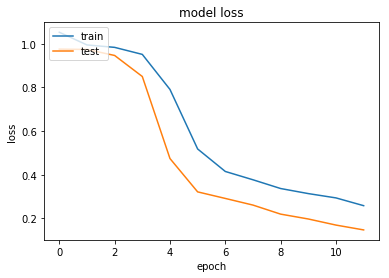

In [51]:
# show plot of loss changes during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model tuning

One of the element of fine tuning model may be selection of the optimization function. In previous iteration I have used Stochastic Gradient Descent. Lets try other:

In [52]:
# create DNN using Keras Sequential API
# I added Dropout to prevent overfitting
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam



model = Sequential()
model.add(Dense(176,input_dim=input_size,kernel_initializer="glorot_uniform",activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(176,kernel_initializer="glorot_uniform",activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(88,kernel_initializer="glorot_uniform",activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(len(languages_dict),kernel_initializer="glorot_uniform",activation="softmax"))
model_optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer=model_optimizer,
              metrics=['accuracy'])

In [53]:
# let's fit the data
# history variable will help us to plot results later
history = model.fit(X_train,y_train,
          epochs=12,
          validation_split=0.10,
          batch_size=64,
          verbose=2,
          shuffle=True)

Train on 10418 samples, validate on 1158 samples
Epoch 1/12
 - 1s - loss: 0.6481 - acc: 0.7196 - val_loss: 0.1317 - val_acc: 0.9689
Epoch 2/12
 - 1s - loss: 0.1609 - acc: 0.9585 - val_loss: 0.0909 - val_acc: 0.9758
Epoch 3/12
 - 1s - loss: 0.1358 - acc: 0.9654 - val_loss: 0.0873 - val_acc: 0.9750
Epoch 4/12
 - 1s - loss: 0.1254 - acc: 0.9654 - val_loss: 0.0851 - val_acc: 0.9724
Epoch 5/12
 - 1s - loss: 0.1133 - acc: 0.9677 - val_loss: 0.0807 - val_acc: 0.9724
Epoch 6/12
 - 1s - loss: 0.1098 - acc: 0.9661 - val_loss: 0.0787 - val_acc: 0.9724
Epoch 7/12
 - 1s - loss: 0.1038 - acc: 0.9680 - val_loss: 0.0778 - val_acc: 0.9706
Epoch 8/12
 - 1s - loss: 0.0972 - acc: 0.9671 - val_loss: 0.0747 - val_acc: 0.9741
Epoch 9/12
 - 1s - loss: 0.0923 - acc: 0.9686 - val_loss: 0.0751 - val_acc: 0.9750
Epoch 10/12
 - 1s - loss: 0.0915 - acc: 0.9676 - val_loss: 0.0718 - val_acc: 0.9706
Epoch 11/12
 - 1s - loss: 0.0829 - acc: 0.9697 - val_loss: 0.0715 - val_acc: 0.9715
Epoch 12/12
 - 1s - loss: 0.0809 - a

In [54]:

# What is our model real accuracy tested on unseen data?
scores = model.evaluate(X_test, y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

2895/2895 [==============================] - 0s 50us/step
acc: 97.55%


In [56]:

# and now we will prepare data for scikit-learn classification report
Y_pred = model.predict_classes(X_test)
Y_pred = to_categorical(Y_pred, num_classes=len(languages_dict))

In [57]:
# and run the report
target_names =  list(languages_dict.keys())
print(classification_report(y_test, Y_pred, target_names=target_names))

             precision    recall  f1-score   support

    english       0.98      0.98      0.98      1172
     french       0.99      0.99      0.99      1344
     german       0.94      0.94      0.94       379

avg / total       0.98      0.98      0.98      2895



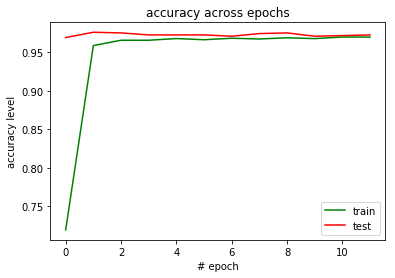

In [58]:
# show plot accuracy changes during training
plt.plot(history.history['acc'],'g')
plt.plot(history.history['val_acc'],'r')
plt.title('accuracy across epochs')
plt.ylabel('accuracy level')
plt.xlabel('# epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

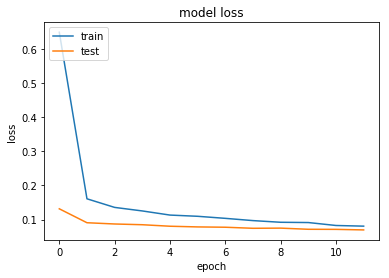

In [59]:
# show plot of loss changes during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Deployment

In [60]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

# Conclusions
DNN performed slightly better, than stop words analysis. Bad performance of the DNN migh be connected to smaller batch of German data set, which was few times smaller, than French or English. Changing data source migh increase accuracy to 98-99%